In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from numpy import array, zeros, ones, eye, dot
from numpy.random import normal
import matplotlib.pyplot as plt
from numba import jit 

In [2]:
class EnsembleDA(object):

    # 使用するnumpy配列の宣言,  配列の初期設定やゼロ設定
    def __init__(self, dim_x, dim_y, Np, fx, hx, n_var, var_shape, n_par, par_init_m, par_init_sd, par_noise_sd, sd_pert, dt, stepmax, stepobs, stepout, rseed):
        self.dim_x = dim_x # 拡大状態ベクトルの次元
        self.dim_y = dim_y # 観測ベクトルの次元
        self.Np = Np # アンサンブル数
        self.fx = fx # 状態ベクトルを更新するシミュレーションモデル. 状態空間モデルにおけるf(x)
        self.hx = hx # 観測演算子h_t
        self.n_var = n_var # 状態変数の種類の個数
        self.var_shape = var_shape # 状態ベクトルの大きさを含むリスト
        self.n_par = n_par # 推定するパラメータの個数
        self.par_init_m = par_init_m # 推定するパラメータの初期推定値のアンサンブルの平均値
        self.par_init_sd = par_init_sd # 推定するパラメータの初期推定値のアンサンブルの標準偏差
        self.par_noise_sd = par_noise_sd # 推定するパラメータに加えるシステムノイズv_tの標準偏差. 平均値は0.
        self.par_sv_idx = dim_x - n_par # 拡大状態ベクトルの成分のうちパラメータが格納されている成分のindex
        self.sd_pert = sd_pert # 観測ノイズw_tの標準偏差. 平均値は0.
        self.dt = dt # シミュレーションの時間増分
        self.stepmax = stepmax # 全時間ステップ数
        self.stepobs = stepobs # 観測データの時間間隔
        self.stepout = stepout # 計算結果の出力間隔（本プログラムでは, stepobsと同じ）
        self.Xt = zeros((dim_x, Np)) # 拡大状態ベクトルのアンサンブルメンバー
        self.Xtt = zeros((dim_x, Np))
        self.ytvec = zeros(dim_y) # 観測ベクトル y_t
        self.xt_mean = zeros(dim_x) # 拡大状態ベクトルのアンサンブル平均
        self.xt_sd = zeros(dim_x) # 拡大状態ベクトルのアンサンブルメンバーの標準偏差
        self.stvar = [[zeros(var_shape[i]) for i in range(n_var)] for j in range(Np)] # 状態ベクトル x_t
        self.var_size = [self.stvar[0][i].size for i in range(n_var)]
        self.i_start = zeros(n_var, dtype=int)
        self.i_end = zeros(n_var, dtype=int)
        self.i_end[0] = self.var_size[0]
        if n_var >= 2:
            for i in range(1, n_var):
                self.i_start[i] = self.i_end[i-1]
                self.i_end[i] = self.i_end[i-1] + self.var_size[i]
        np.random.seed(rseed)

    # 状態ベクトルx_tのアンサンブルメンバーにフェーズフィールド変数と温度場の初期値を代入. 本プログラムでは, 全てのアンサンブルで同じ初期状態とする.
    def initialize_stvar(self, *var):
        for ip in range(self.Np):
            for i_var in range(self.n_var):
                self.stvar[ip][i_var][:] = var[i_var].copy()

    # 推定対象となるパラメータの初期値のアンサンブルを拡大状態ベクトルX_tに代入する 
    def initialize_param(self):
        for i in range(self.n_par):
            e = normal(self.par_init_m[i], self.par_init_sd[i], self.Np) # 推定対象となるパラメータの初期値は乱数を用いてばらつかせる
            self.Xt[self.par_sv_idx+i, :] = e[:]

    # 拡大状態ベクトルX_tに状態ベクトルx_tの中身を代入する
    def set_stvar_to_sv(self, i_var, ip):
        i_start = self.i_start[i_var]
        i_end = self.i_end[i_var]
        self.Xt[i_start:i_end, ip] = self.stvar[ip][i_var].flatten(order='F')

    # 状態ベクトルx_rから状態変数を抜き出す 
    def get_stvar_from_sv(self, i_var, ip):
        i_start = self.i_start[i_var]
        i_end = self.i_end[i_var]
        shape = self.var_shape[i_var]
        self.stvar[ip][i_var][:] = self.Xt[i_start:i_end, ip].reshape(shape, order='F').copy()

    # 観測ベクトルをnumpy配列に代入する. 観測データの数はstepmax/stepobsの値と一致しなければならない
    def set_obsdata(self, obsdata):
        self.obsdata = obsdata

    # 観測データから抜き出したデータを観測ベクトルy_tに代入する. 
    def set_obsvec(self, iobs):
        self.ytvec = self.obsdata[iobs-1].flatten(order='F')

    # 推定した状態変数とパラメータのアンサンブル平均と標準偏差を計算する
    def calc_mean_and_sd(self):
        for i in range(self.dim_x):
            self.xt_mean[i] = np.mean(self.Xt[i, :]) # アンサンブル平均
            self.xt_sd[i] = np.std(self.Xt[i, :], ddof=1) # 標準偏差

    # 推定した状態変数のアンサンブル平均と標準偏差を計算する
    def get_mean_and_sd(self, i_var):
        i_start = self.i_start[i_var]
        i_end = self.i_end[i_var]
        shape = self.var_shape[i_var]
        return self.xt_mean[i_start:i_end].reshape(shape, order='F').copy(), \
        self.xt_sd[i_start:i_end].reshape(shape, order='F').copy()

    # 状態ベクトルから推定したパラメータを抜き出す 
    def get_param_from_sv(self, ip):
        return self.Xt[self.par_sv_idx:self.dim_x, ip]

    # 推定するパラメータにシステムノイズを加える 
    def add_systemnoise(self):
        Np = self.Np
        n_par = self.n_par
        par_noise_sd = self.par_noise_sd
        par_sv_idx = self.par_sv_idx

        for i in range(n_par):
            e = normal(0.0, par_noise_sd[i], Np)
            self.Xt[par_sv_idx+i, :] += e[:]

    # 推定した状態変数やパラメータの結果を画像で出力する 
    def output(self, nstep):
        Np = self.Np
        n_var = self.n_var
        n_par = self.n_par

        [self.set_stvar_to_sv(i_var, ip) for i_var in range(n_var) for ip in range(Np)]
        self.calc_mean_and_sd()

        for i in range(n_var): # i=0: phase-field, i=1: temperature
            mean, sd = self.get_mean_and_sd(i)            
            if i == 0: # 観測データと推定値の比較
              print("STEP=", nstep)
              print("Phase-field, Left: Estimation, Right: Observation")
              plt.figure(figsize=(15,5))
              plt.subplot(131)
              plt.imshow(mean, cmap='binary')
              plt.colorbar()
              plt.subplot(132)
              plt.imshow(obsdata[int(nstep/stepobs)-1], cmap='binary')
              plt.colorbar()
              plt.subplot(133)
              plt.imshow(obsdata[int(nstep/stepobs)-1]-mean, cmap='binary')
              plt.colorbar()
              #plt.show()
              plt.savefig('estm{}.pdf'.format(nstep), format="pdf", dpi=300)

    # 状態ベクトルの更新. つまりフェーズフィールドモデルを用いて一期先予測を行う 
    def update(self):
        for i in range(self.Np):
            para = self.get_param_from_sv(i) # 拡大状態ベクトルからパラメータだけを抜き出す
            self.stvar[i] = self.fx(*self.stvar[i][:], *para) # 抜き出したパラメータを使ってシミュレーションを実行(以下のコードセルで定義するfxを呼び出す)
        self.add_systemnoise() # シミュレーション結果に対してシステムノイズを加える

    # class EnsembleKalmanFilterにあるfilteringを実行する 
    def filtering(self):
        pass

    # 一期先予測とフィルタリングを繰り返すルーチン
    def run(self):
        Np = self.Np
        n_var = self.n_var
        stepmax = self.stepmax
        stepobs = self.stepobs
        stepout = self.stepout
        param0_mean = []
        param0_std = []
        param1_mean = []
        param1_std = []
        
        for nstep in range(1, stepmax+1): # 一期先予測の時間ループ
            self.update() # 一期先予測の実行(つまりシミュレーションを1ステップ進める)
            if nstep % stepobs == 0: # 観測データが存在する時刻では, フィルタリングを実行する
                iobs = int(nstep / stepobs) # フィルタリングの回数
                [self.set_stvar_to_sv(i_var, ip) for i_var in range(n_var) for ip in range(Np)] # 状態ベクトルから状態変数を抜き出す
                self.set_obsvec(iobs) # 比較する観測ベクトルを設定
                self.filtering() # フィルタリングを実行し, 事後分布のアンサンブルメンバを求める
                [self.get_stvar_from_sv(i_var, ip) for i_var in range(n_var) for ip in range(Np)] # フィルタリングで修正された状態変数を状態ベクトルに戻す
            if nstep % stepout == 0: # 計算結果を出力する
                self.output(nstep)
                param0_mean.append(self.xt_mean[ self.par_sv_idx+0])
                param0_std.append(self.xt_sd[self.par_sv_idx+0])
                param1_mean.append(self.xt_mean[ self.par_sv_idx+1])
                param1_std.append(self.xt_sd[self.par_sv_idx+1])                

        fig=plt.figure(figsize=(12,10))
        plt.rcParams["font.size"] = 15
        plt.subplot(2,1,1)
        plt.plot(param0_mean,'o-')
        plt.grid()
        plt.xlim(0,stepmax/stepobs)
        plt.ylim(0.02,0.05)
        plt.xlabel('Number of filtering')
        plt.ylabel('Ensemble mean of \n estimated anisotropy strength')

        plt.subplot(2,1,2)
        plt.plot(param0_std,'o-')
        plt.grid()
        plt.xlim(0,stepmax/stepobs)
        plt.ylim(0.,0.008)
        plt.xlabel('Number of filtering')
        plt.ylabel('Standard deviation of \n  estimated anisotropy strength')
        #plt.show()
        plt.savefig('graph1.pdf'.format(nstep), format="pdf", dpi=300)

        fig=plt.figure(figsize=(12,10))
        plt.rcParams["font.size"] = 15
        plt.subplot(2,1,1)
        plt.plot(param1_mean,'o-')
        plt.grid()
        plt.xlim(0,stepmax/stepobs)
        plt.ylim(0.2,0.5)
        plt.xlabel('Number of filtering')
        plt.ylabel('Ensemble mean of \n  estimated interfacial energy [J/m2]')

        plt.subplot(2,1,2)
        plt.plot(param1_std,'o-')
        plt.grid()
        plt.xlim(0,stepmax/stepobs)
        plt.ylim(0.,0.05)
        plt.xlabel('Number of filtering')
        plt.ylabel('Standard deviation of \n estimated interfacial energy [J/m2]')
        #plt.show()
        plt.savefig('graph2.pdf'.format(nstep), format="pdf", dpi=300)

        print("Ensemble mean of estimated anisotropy strength =", self.xt_mean[self.par_sv_idx+0])
        print("Standard deviation of estimated anisotropy strength =", self.xt_sd[self.par_sv_idx+0])
        print("Ensemble mean of estimated interfacial energy =", self.xt_mean[self.par_sv_idx+1])
        print("Standard deviation of estimated interfacial energy =", self.xt_sd[self.par_sv_idx+1])

In [3]:
class EnsembleKalmanFilter(EnsembleDA):

    def __init__(self, dim_x, dim_y, Np, fx, hx, n_var, var_shape, n_par, par_init_m, par_init_sd, par_noise_sd, sd_pert, dt, stepmax, stepobs, stepout, rseed):

        super().__init__(dim_x, dim_y, Np, fx, hx, n_var, var_shape, n_par, par_init_m, par_init_sd, par_noise_sd, sd_pert, dt, stepmax, stepobs, stepout, rseed)

        self.Yt = zeros((dim_y, Np)) # 観測ベクトルのアンサンブル(Y_t)
        self.Wt = zeros((dim_y, Np)) # 観測ノイズのアンサンブル(w_t^(i))
        self.Wtt = zeros((dim_y, Np)) # 観測ベクトルに加える擾乱(W_t)
        # self.Rtinv = zeros((Np, dim_y))
        self.S = zeros((dim_y, Np)) # カルマンゲインを計算するための配列(補足資料参照)
        self.Mat1 = ones((Np, Np)) # 単位行列I
        self.Mpp1 = zeros((Np, Np)) # カルマンゲインを計算するための配列(補足資料参照)
        self.Mpp2 = zeros((Np, Np)) # カルマンゲインを計算するための配列(補足資料参照)
        self.Mpp3 = zeros((Np, Np)) # カルマンゲインを計算するための配列(補足資料参照)
        self.Mpy = zeros((Np, dim_y)) # カルマンゲインを計算するための配列(補足資料参照)
        self.inv = np.linalg.inv # 逆行列の計算

    # EnKFに基づき事後分布を求める. つまりfilteringを実施する
    def filtering(self):
        Np = self.Np # アンサンブルサイズ
        sd_pert = self.sd_pert # 観測ノイズの標準偏差
        dim_y = self.dim_y # 観測ベクトルの次元
        hx = self.hx # 観測行列H_t

        for i in range(Np):
            self.Yt[:, i] = self.ytvec[:] # 同化する観測ベクトル(Y_t = [y_t, y_t, ..., y_t])を設定 

        for i in range(dim_y):
            self.Wt[i, :] = normal(0.0, sd_pert, Np) # 観測ノイズのアンサンブル(w_t^(i))の設定(平均0) 
            # self.Rtinv[:, i] = 1.0 / np.var(self.Wt[i, :], ddof=1)

        self.Wtt = self.Wt - (1.0/Np) * dot(self.Wt, self.Mat1) # 観測ベクトルに加える擾乱(W_t)を計算 
        self.Yt += self.Wtt # 観測ベクトルに擾乱を加える (Y_t + W_tを計算)
        # self.Yt[0:dim_y, 0:Np] -= self.Xt[0:dim_y, 0:Np]

        self.Yt[0:dim_y, 0:Np] -= array([hx(self.Xt[:, i]) for i in range(Np)]).T # イノベーション(Y_t + W_t - H_t*X_t|t-1)を計算

        self.Xtt = self.Xt - (1.0/Np) * dot(self.Xt, self.Mat1) # 各アンサンブルとアンサンブル平均の差(tilda(X)_t|t-1 = [x_t|t-1^(i) - bar(x)_t|t-1, ...])を計算
        # self.S[0:dim_y, 0:Np] = self.Xtt[0:dim_y, 0:Np]

        self.S[0:dim_y, 0:Np] = array([hx(self.Xtt[:, i]) for i in range(Np)]).T # S_t = (H_t * X_t|t-1)/sqrt(Np-1) (ただし1/sqrt(Np-1)で除するのは, 次の行でまとめて計算) 

        self.Mpy = self.S.T * (1.0/(sd_pert*sd_pert*(Np-1))) # S_t^T * R_t^(-1)  (ここで, R_tは対角行列とし, その成分はsd_part^2であることに注意. 1/(Np-1)となるのは、Z_t|t-1との積を考慮)
        # self.Mpy = (self.S.T * self.Rtinv) * (1.0/(Np-1))

        self.Mpp1 = eye(Np) + dot(self.Mpy, self.S) # I + S_t^T * R_t^(-1) * S_t

        self.Mpp2 = dot(self.Mpy, self.Yt) # S_t^T * R_t^(-1) * (Y_t + W_t - H_t*X_t|t-1)

        self.Mpp3 = dot(self.inv(self.Mpp1), self.Mpp2) # (I + S_t^T * R_t^(-1) * S_t)^-1 * S_t^T * R_t^(-1) * (Y_t + W_t - H_t*X_t|t-1)

        self.Xt += dot(self.Xtt, self.Mpp3) # アンサンブルメンバーを更新(X_t|t = X_t|t-1 + Z_t|t-1 * (I + S_t^T * R_t^(-1) * S_t)^-1 * S_t^T * R_t^(-1) * (Y_t + W_t - H_t*X_t|t-1)) を計算


STEP= 50
Phase-field, Left: Estimation, Right: Observation
STEP= 100
Phase-field, Left: Estimation, Right: Observation
STEP= 150
Phase-field, Left: Estimation, Right: Observation
STEP= 200
Phase-field, Left: Estimation, Right: Observation
STEP= 250
Phase-field, Left: Estimation, Right: Observation
STEP= 300
Phase-field, Left: Estimation, Right: Observation
STEP= 350
Phase-field, Left: Estimation, Right: Observation
STEP= 400
Phase-field, Left: Estimation, Right: Observation
STEP= 450
Phase-field, Left: Estimation, Right: Observation
STEP= 500
Phase-field, Left: Estimation, Right: Observation
STEP= 550
Phase-field, Left: Estimation, Right: Observation
STEP= 600
Phase-field, Left: Estimation, Right: Observation
STEP= 650
Phase-field, Left: Estimation, Right: Observation
STEP= 700
Phase-field, Left: Estimation, Right: Observation
STEP= 750
Phase-field, Left: Estimation, Right: Observation
STEP= 800
Phase-field, Left: Estimation, Right: Observation
STEP= 850
Phase-field, Left: Estimation, 

<ipython-input-2-496c9381ca7c>:165: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(12,10))


Ensemble mean of estimated anisotropy strength = 0.029918526245187742
Standard deviation of estimated anisotropy strength = 0.003480388762597109
Ensemble mean of estimated interfacial energy = 0.3693957543476479
Standard deviation of estimated interfacial energy = 0.024691273783


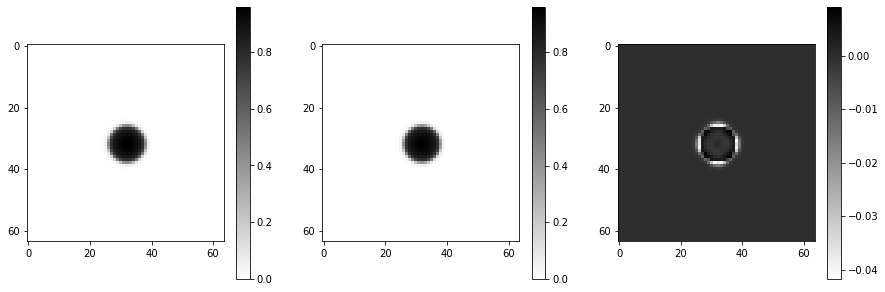

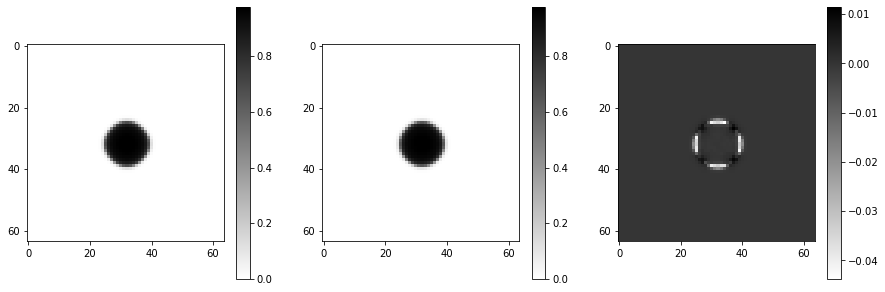

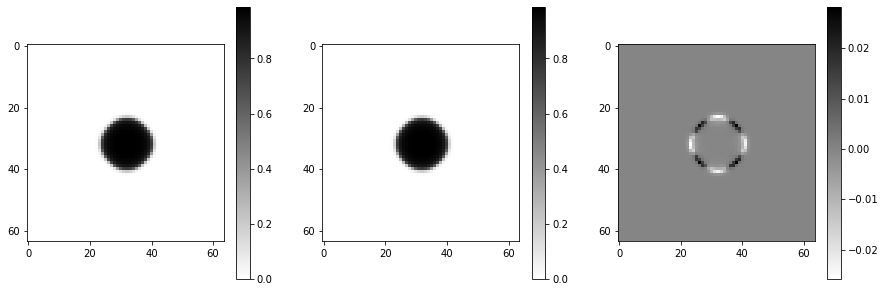

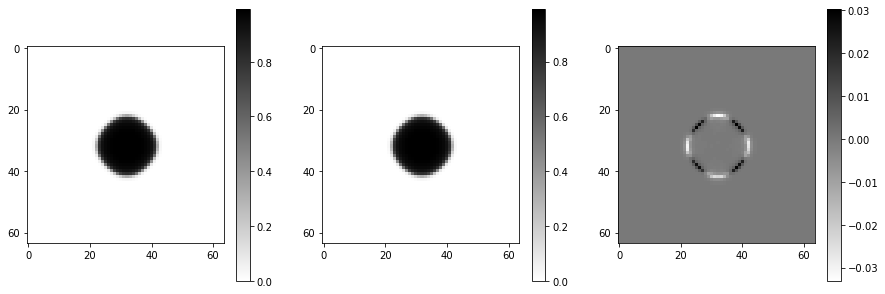

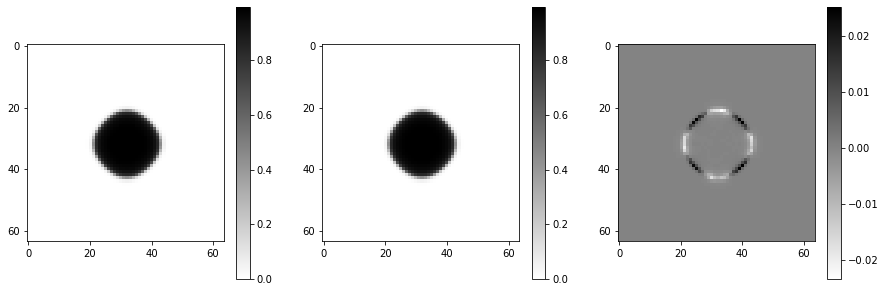

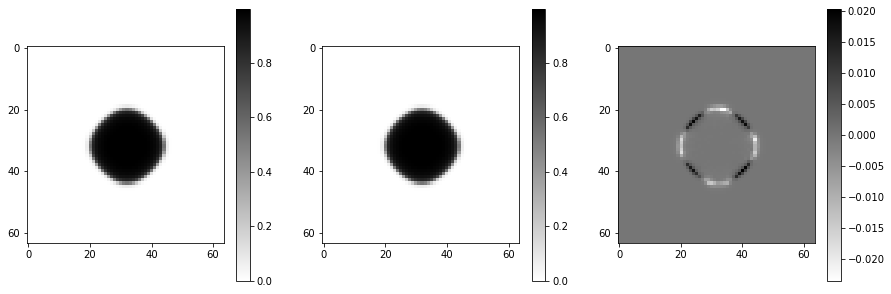

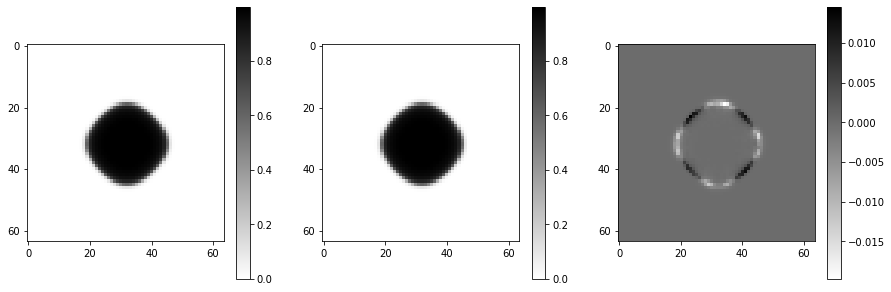

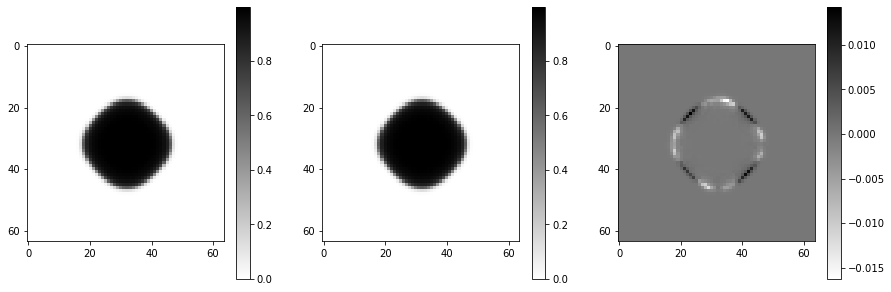

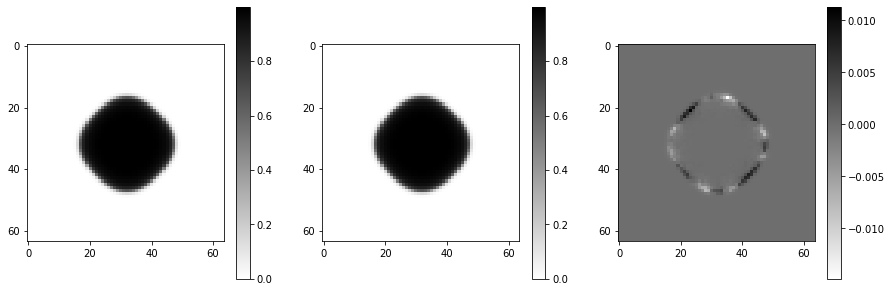

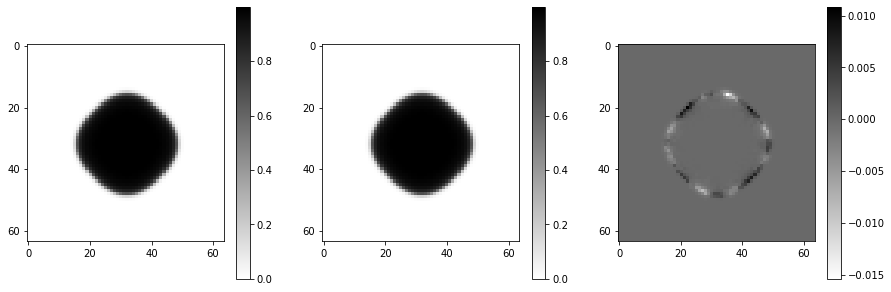

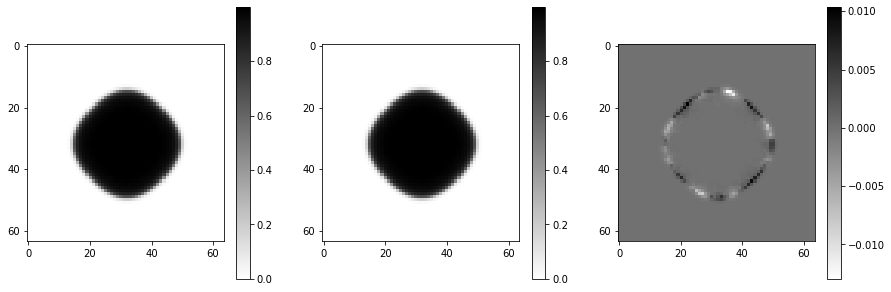

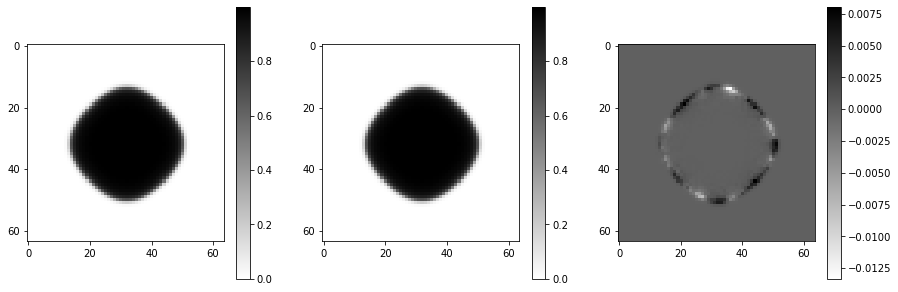

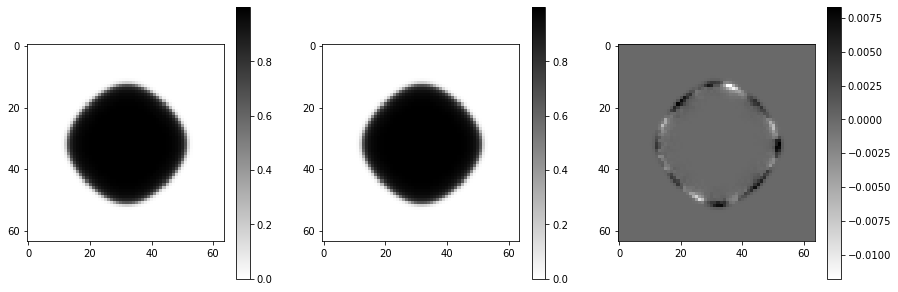

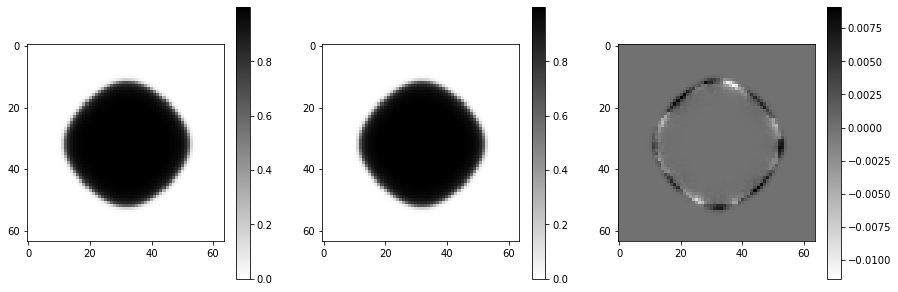

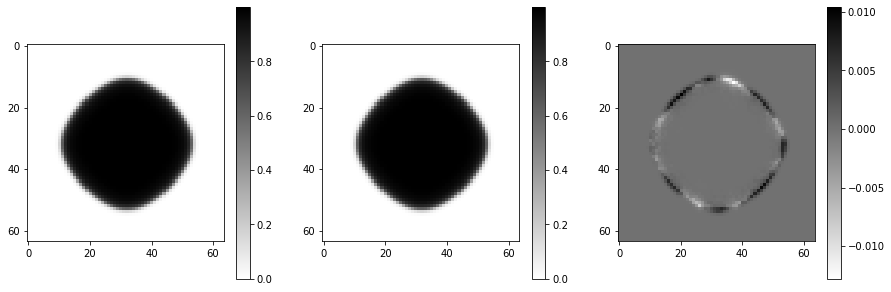

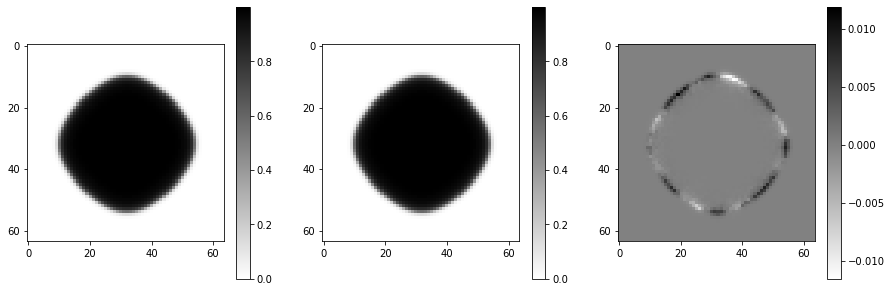

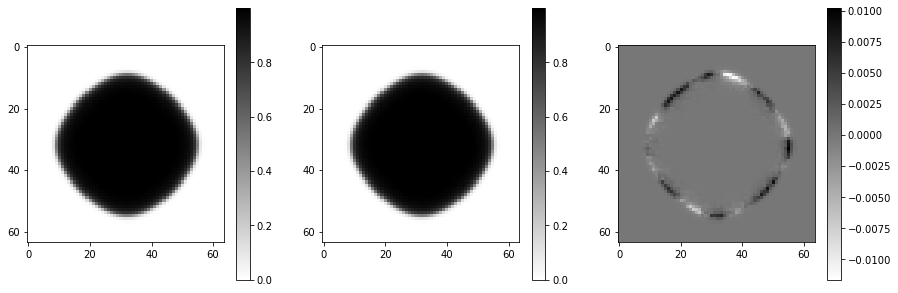

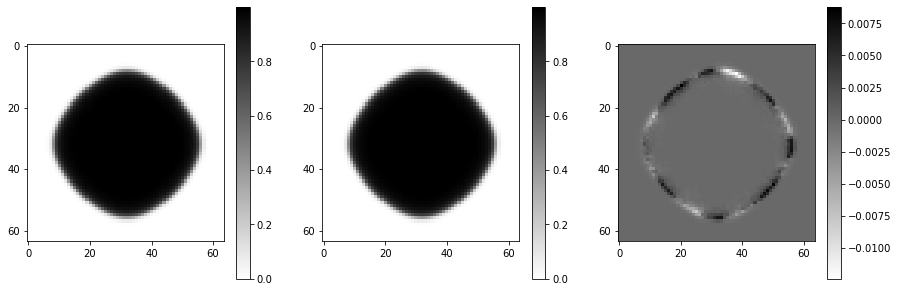

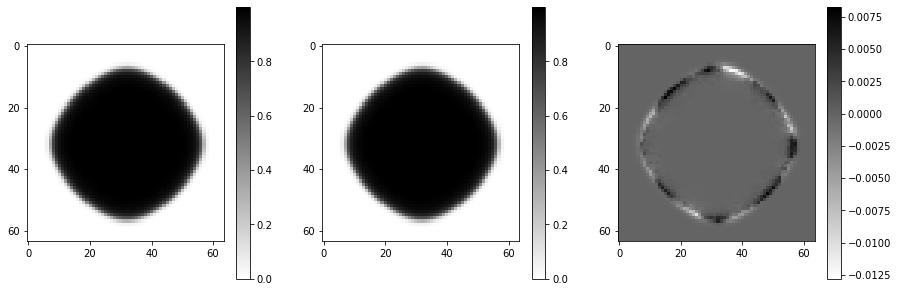

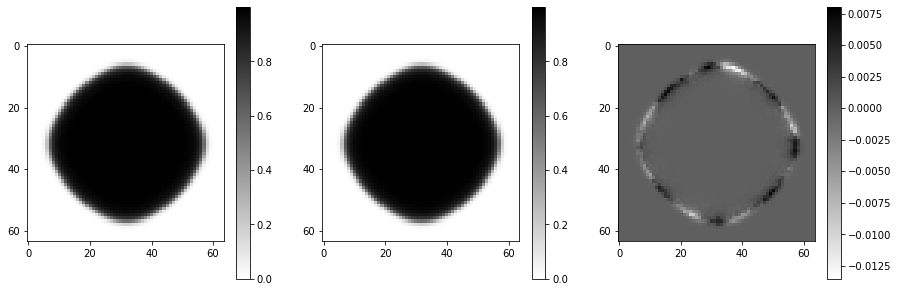

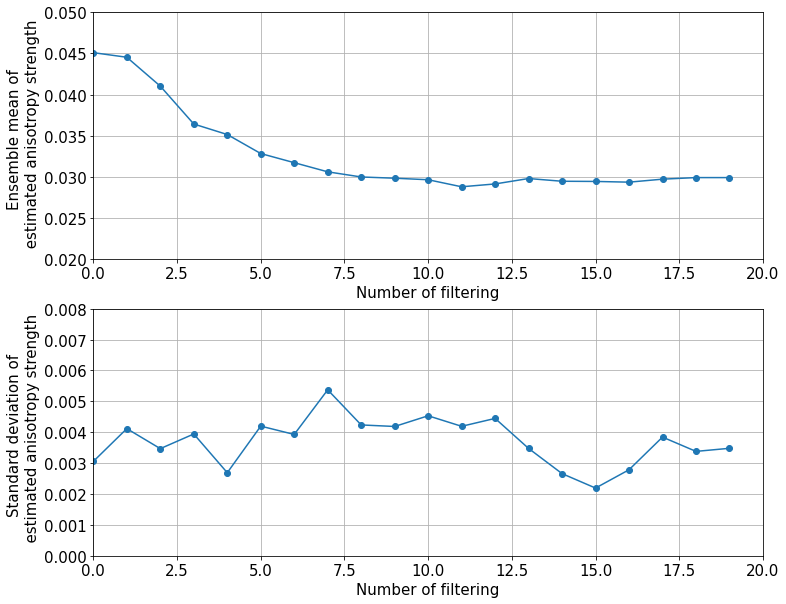

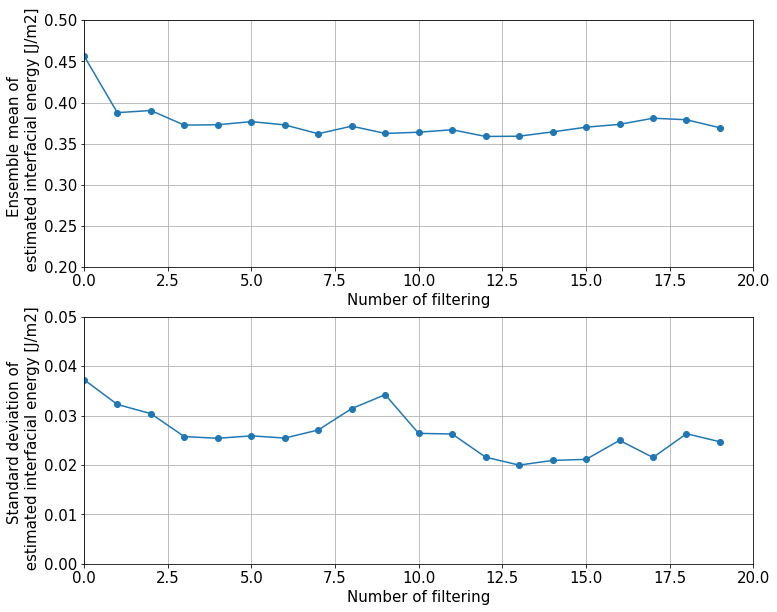

In [4]:
# フェーズフィールドシミュレーションに関するパラメータ
nx = 64 # x方向の差分格子点数
ny = nx # y方向の差分格子点数
n_grid = nx * ny # 全差分格子点数
dx = 2.0e-08 # 差分格子点の間隔[um]
dy = dx
dt = 5.0e-12 # 時間増分[s]
stepmax = 1000 # 時間ステップ数
stepobs = 50 # 観測時間間隔
stepout = stepobs # 結果出力間隔
pi = np.pi # 円周率
delta = 4.0 * dx # 界面幅
gamma = 0.37 # 界面エネルギー(今回推定するパラメータ) [J/m2]
zeta = 0.03 # 異方性強度(今回推定するパラメータ)
aniso = 4.0 # 異方性モード数
angle0 = 0.0 # 優先成長方向
T_melt = 1728 # 融点[K]
K = 84.01 # 熱伝導率[www/(mK)]
c = 5.42e+06 # 比熱[J/K]
latent = 2.35e+09 # 潜熱 [J/mol]
lamb = 0.1
b = 2.0 * np.arctanh(1.0-2.0*lamb)
mu = 2.0 # 界面カイネティック係数 [m/(Ks)]
kappa = K / c # 熱拡散係数
a0 = np.sqrt(3.0*delta*gamma/b) # 勾配エネルギー係数
www = 6.0 * gamma * b / delta # ダブルウェルポテンシャルのエネルギー障壁の高さ
pmobi = b * T_melt * mu / (3.0 * delta * latent) # フェーズフィールドモビリティー 
T_0 = 1424.5 # 温度[K]
init_size = 10 # 固相の初期核の大きさ[grid]

# データ同化に関するパラメータ
n_var = 2 # 状態変数の種類の数　　今回はフェーズフィールド（phi）と温度（temp）の2種類なのでn_var=2
var_shape = [(nx, ny), (nx, ny)] # 状態変数の配列の形 フェーズフィールドと温度の2つ
n_par = 2 # 推定するパラメータの数
dim_x = n_var*nx*ny + n_par # 拡大状態ベクトルの次元
dim_y = nx*ny # 観測ベクトルの次元 = 差分格子点と同じ位置・個数で観測データが得られたと仮定
Np = 20 # アンサンブルサイズ
par_init_m = np.array([0.045, 0.5]) # 推定するパラメータの初期平均値(異方性強度, 界面エネルギーの順)
par_init_sd = np.array([0.005, 0.05]) # 推定するパラメータの初期標準偏差
par_noise_sd = np.array([0.01*zeta, 0.01*gamma]) # システムノイズの標準偏差
sd_pert = 0.1 # 観測ノイズの標準偏差
rseed = 1000 # 乱数生成器のシード

# numpy配列の確保
phi = np.zeros((nx,ny)) # フェーズフィールド変数
temp = np.zeros((nx,ny)) # 温度変数
grad_phix = np.zeros((nx,ny)) # 秩序変数phiのx方向勾配
grad_phiy = np.zeros((nx,ny)) # 秩序変数phiのy方向勾配
a2 = np.zeros((nx,ny)) # 勾配エネルギー係数の2乗
lap_temp = np.zeros((nx,ny)) # 温度tempのラプラシアン
lap_phi = np.zeros((nx,ny)) # 秩序変数phiのラプラシアン
ax = np.zeros((nx,ny)) # A'
ay = np.zeros((nx,ny)) # B'

# フェーズフィールドモデル計算(勾配やラプラシアンの計算)
# 純物質凝固のフェーズフィールドモデルと同じ関数
@jit(nopython=True)
def calcgrad(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2):
    for j in range(ny):
        for i in range(nx):
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            if ip > nx-1:
                ip = nx - 1
            if im < 0:
                im = 0
            if jp > ny-1:
                jp = ny - 1
            if jm < 0:
                jm = 0

            grad_phix[i,j] = (phi[ip,j]-phi[im,j])/(2.*dx)
            grad_phiy[i,j] = (phi[i,jp]-phi[i,jm])/(2.*dy)
            lap_phi[i,j] = (phi[ip,j]+phi[im,j]+phi[i,jp]+phi[i,jm]-4.*phi[i,j])/(dx*dx)
            lap_temp[i,j]= (temp[ip,j]+temp[im,j]+temp[i,jp]+temp[i,jm]-4.*temp[i,j])/(dx*dx)

            if grad_phix[i,j] == 0.:
                if grad_phiy[i,j] > 0.:
                    angle = 0.5*pi
                else:
                    angle = -0.5*pi
            elif grad_phix[i,j] > 0.:
                if grad_phiy[i,j] > 0.:
                    angle = np.arctan(grad_phiy[i,j]/grad_phix[i,j])
                else:
                    angle = 2.0*pi + np.arctan(grad_phiy[i,j]/grad_phix[i,j])
            else:
                angle = pi + np.arctan(grad_phiy[i,j]/grad_phix[i,j])

            a = a0*(1. + zeta * np.cos(aniso*(angle-angle0)))
            dadtheta = -a0*aniso*zeta*np.sin(aniso*(angle-angle0))
            ay[i,j] = -a * dadtheta * grad_phiy[i,j]
            ax[i,j] =  a * dadtheta * grad_phix[i,j]
            a2[i,j] = a * a

# フェーズフィールドモデル計算 (時間発展方程式の計算)
# 純物質凝固のフェーズフィールドモデルと同じ関数
@jit(nopython=True)
def timeevol(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2):
    for j in range(ny):
        for i in range(nx):
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            if ip > nx-1:
                ip = nx - 1
            if im < 0:
                im = 0
            if jp > ny-1:
                jp = ny -1
            if jm < 0:
                jm = 0

            dxdy = (ay[ip,j]-ay[im,j])/(2.*dx)
            dydx = (ax[i,jp]-ax[i,jm])/(2.*dy)
            grad_a2x = (a2[ip,j]-a2[im,j])/(2.*dx)
            grad_a2y = (a2[i,jp]-a2[i,jm])/(2.*dy)
            tet = phi[i,j]
            drive = -latent * (temp[i,j]-T_melt) / T_melt
            scal = grad_a2x*grad_phix[i,j]+grad_a2y*grad_phiy[i,j]

            chi = 0.0
            if tet > 0.0 and tet < 1.0:
                chi = np.random.uniform(-0.1,0.1)
            phi[i,j] = phi[i,j] + (dxdy + dydx + a2[i,j]*lap_phi[i,j] + scal + 4.0*www*tet*(1.0-tet)*(tet-0.5+15.0/(2.0*www)*drive*tet*(1.0-tet)+chi))*dt*pmobi
            temp[i,j] = temp[i,j] + kappa*lap_temp[i,j]*dt + 30.0*tet*tet*(1.0-tet)*(1.0-tet)*(latent/c)*(phi[i,j]-tet)

@jit(nopython=True)
def fx(phi, temp, zeta, gamma): # fxの引数は状態変数の配列と推定するパラメータのみ

    # 推定したパラメータでフェーズフィールドパラメータepsとWを再計算する必要がある
    a0 = np.sqrt(3.0*delta*gamma/b)
    www = 6.0 * gamma * b / delta

    # 時間発展の計算の途中で用いる配列は、fxの中で定義する(配列への代入を行わないなら外で定義してもよい)
    grad_phix = np.zeros((nx,ny))
    grad_phiy = np.zeros((nx,ny))
    a2 = np.zeros((nx,ny))
    lap_temp = np.zeros((nx,ny))
    lap_phi = np.zeros((nx,ny))
    ax = np.zeros((nx,ny))
    ay = np.zeros((nx,ny))

    calcgrad(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2)
    timeevol(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2)

    return [phi, temp] # fxの戻り値は1 stepの計算後の状態変数の配列を含むリスト

# 観測ベクトルの定義
def hx(xt):
    return xt[0:dim_y] # 観測データとして秩序変数phiを用いるのでhxは状態ベクトルからPF変数のみを取り出す

# フェーズフィールドと温度の初期値の設定(純物質凝固のフェーズフィールドモデルと同じ)
r0 = 3.*dx
for j in range(0,ny):
    for i in range(0,nx):
#        if i+j < init_size:
#            phi[i,j] = 1.0
#        temp[i,j] = T_0 + phi[i,j] * (T_melt-T_0)
        phi[i,j] = 0.0
        x = dx*(i-nx/2)
        y = dy*(j-ny/2)
        r = np.sqrt(x*x + y*y)
        phi[i,j] = 0.5*(1.-np.tanh(np.sqrt(2.*www)/(2.*a0)*(r-r0)))
        if phi[i,j] <= 1.0e-5:
            phi[i,j] = 0.0
        temp[i,j] = T_0 + phi[i,j] * (T_melt-T_0)
                
# EnKFのclassの初期設定
EnKF = EnsembleKalmanFilter(dim_x=dim_x, dim_y=dim_y, Np=Np, fx=fx, hx=hx, n_var=n_var, var_shape=var_shape, n_par=n_par, \
    par_init_m=par_init_m, par_init_sd=par_init_sd, par_noise_sd=par_noise_sd, sd_pert=sd_pert, dt=dt, stepmax=stepmax, stepobs=stepobs, stepout=stepout, rseed=rseed)

EnKF.initialize_stvar(phi, temp) # 各アンサンブルメンバーのphiとtempに上で設定した初期値を代入する(全アンサンブルメンバーで同じ初期状態. パラメータは異なる値.)
EnKF.initialize_param() # 推定するパラメータの初期分布を作成する

nstep = 0
obsdata = []

# パラメータを真値に設定し, 擬似観測データを得るためのシミュレーションを行う. 
for nstep in range(1,stepmax+1):
    calcgrad(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2)
    timeevol(phi,temp,zeta,a0,www,grad_phix,grad_phiy,lap_phi,lap_temp,ax,ay,a2)
    if (nstep % stepobs) == 0:
        obsdata.append(phi.copy()) # 各時刻の擬似観測データ(秩序変数phi)をリストに

EnKF.set_obsdata(obsdata) # 上記で計算した擬似観測データをオブジェクト内の変数に渡す
EnKF.run() # データ同化を実行(一期先予測とフィルタリングの繰り返し)